In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder

from keras import Sequential
from keras.layers import Dense
from helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import time

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
inpDir = os.path.join( '..', 'input')


modelDir = 'Neural Network'

outDir = os.path.join('output')
subDir = 'fashion_mnist'

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE)

ALPHA = 0.001     # learning rate
EPOCHS = 30
BATCH_SIZE = 32
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE=0.2

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

<Figure size 1500x600 with 0 Axes>

In [3]:
data_df = pd.read_csv(os.path.join(inpDir, 'weatherHistory.csv'))

In [4]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),...,Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.47,...,15.83,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.36,...,15.83,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.38,...,14.96,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.29,...,15.83,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.76,...,15.83,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
data_df.tail()

,Formatted Date,Summary,Precip Type,Temperature (C),...,Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.02,...,16.10,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.58,...,15.55,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.04,...,16.10,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.52,...,16.10,0.0,1015.95,Partly cloudy starting in the morning.
96452,2016-09-09 23:00:00.000 +0200,Partly Cloudy,rain,20.44,...,15.52,0.0,1016.16,Partly cloudy starting in the morning.


In [6]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'],utc = True)

In [7]:
temp_df = data_df[['datetime','Temperature (C)']]
temp_df.head()

,datetime,Temperature (C)
0,2006-03-31 22:00:00+00:00,9.47
1,2006-03-31 23:00:00+00:00,9.36
2,2006-04-01 00:00:00+00:00,9.38
3,2006-04-01 01:00:00+00:00,8.29
4,2006-04-01 02:00:00+00:00,8.76


In [8]:
temp_df = temp_df.rename({'Temperature (C)':'temp'},axis = 1)

In [9]:
temp_df = temp_df.sort_values('datetime',axis = 0,ascending=True)
temp_df.reset_index(drop = True,inplace=True)
temp_df.head()
temp_df.tail()

,datetime,temp
96448,2016-12-31 18:00:00+00:00,0.49
96449,2016-12-31 19:00:00+00:00,0.07
96450,2016-12-31 20:00:00+00:00,-0.23
96451,2016-12-31 21:00:00+00:00,-0.47
96452,2016-12-31 22:00:00+00:00,-0.68


<Axes: xlabel='datetime'>

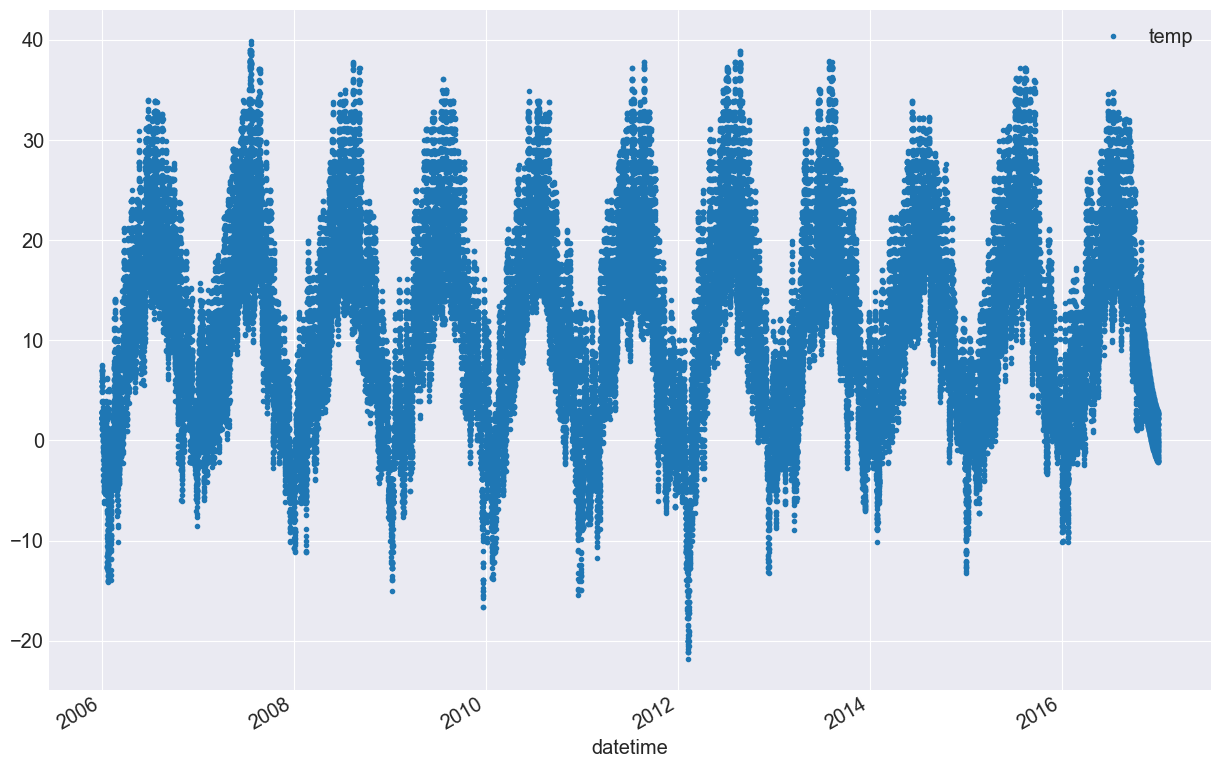

In [10]:
fig,ax = plt.subplots(figsize = (15,10))
temp_df.plot(x = 'datetime',y = 'temp',style = '.',ax = ax)


In [11]:
n_units = 100

input_shape = (1,10000) # A 3D tensor [batch,timesteps,features]

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(input_shape))

model.add(tf.keras.layers.SimpleRNN(units=n_units,activation='tanh'))

model.add(tf.keras.layers.Dense(1,activation='linear'))


In [12]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape
way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape

In [13]:
wax,waa,baa,way,bay

((10000, 100), (100, 100), (100,), (100, 1), (1,))

In [14]:
time_step = 24
y_idx = np.arange(time_step,temp_df.shape[0],time_step)
y_idx

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [15]:
y_df = temp_df.iloc[y_idx]
y_df

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.42
48,2006-01-02 23:00:00+00:00,1.69
72,2006-01-03 23:00:00+00:00,2.20
96,2006-01-04 23:00:00+00:00,1.67
120,2006-01-05 23:00:00+00:00,1.81
...,...,...
96336,2016-12-27 02:00:00+00:00,-1.63
96360,2016-12-28 02:00:00+00:00,-1.68
96384,2016-12-29 02:00:00+00:00,-1.73
96408,2016-12-30 02:00:00+00:00,-1.78


In [16]:
y_df.shape,len(y_df)*time_step

((4018, 2), 96432)

In [17]:
X_df = temp_df.iloc[np.arange(len(y_df)*time_step)]
X_df.shape

(96432, 2)

In [18]:
X = np.reshape(X_df['temp'].to_numpy(),(y_df.shape[0],time_step))
X.shape

(4018, 24)

In [19]:
X = X[:,:23]
X.shape

(4018, 23)

In [20]:
split = int(y_df.shape[0]*(1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]

y_train = y_df['temp'].to_numpy()[:split]
y_test = y_df['temp'].to_numpy()[split:]

In [21]:
n_units = 128

input_shape = (time_step-1,1) # A 3D tensor [batch,timesteps,features]

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(input_shape))

model.add(tf.keras.layers.SimpleRNN(units=n_units,activation='tanh'))

model.add(tf.keras.layers.Dense(1,activation='linear'))

model.compile(loss = 'mean_squared_error',optimizer = 'adam',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 128)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(x = X_train, y = y_train,
                    validation_data = (X_test, y_test),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 45.6633 - root_mean_squared_error: 6.4596 - val_loss: 1.7871 - val_root_mean_squared_error: 1.3550
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9869 - root_mean_squared_error: 1.7213 - val_loss: 1.1455 - val_root_mean_squared_error: 1.0815
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7885 - root_mean_squared_error: 1.3338 - val_loss: 0.9975 - val_root_mean_squared_error: 1.0078
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4444 - root_mean_squared_error: 1.1992 - val_loss: 0.8656 - val_root_mean_squared_error: 0.9402
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2866 - root_mean_squared_error: 1.1325 - val_loss: 0.8105 - val_root_mean_squared_error: 0.9101
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2133 - root_mean_squared_error: 1.1001 - val_loss: 0.9702 - val_root_mean_squared_error: 0.9925
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [24]:
model.evaluate(X_test, y_test, verbose = 2)

26/26 - 0s - 2ms/step - loss: 0.6753 - root_mean_squared_error: 0.8353


[0.6753256320953369, 0.8353205919265747]

In [25]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,19.41,4.42,1.79,1.35
1,2.45,1.57,1.15,1.08
2,1.60,1.27,1.00,1.01
3,1.32,1.15,0.87,0.94
4,1.21,1.10,0.81,0.91


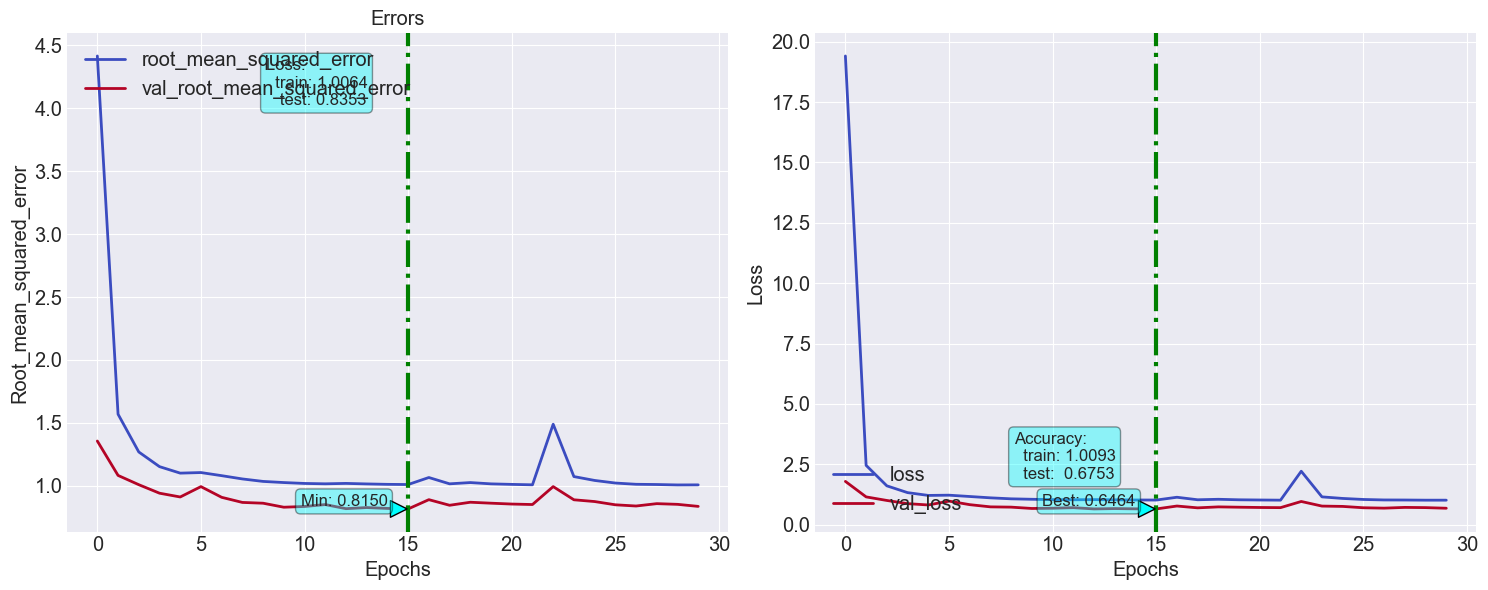

In [26]:
fn_plot_tf_hist(loss_df)

In [27]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred,y_test_pred)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [28]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.42,5.06
48,2006-01-02,1.69,1.62
72,2006-01-03,2.20,2.04
96,2006-01-04,1.67,1.90
120,2006-01-05,1.81,2.24


<Axes: xlabel='datetime'>

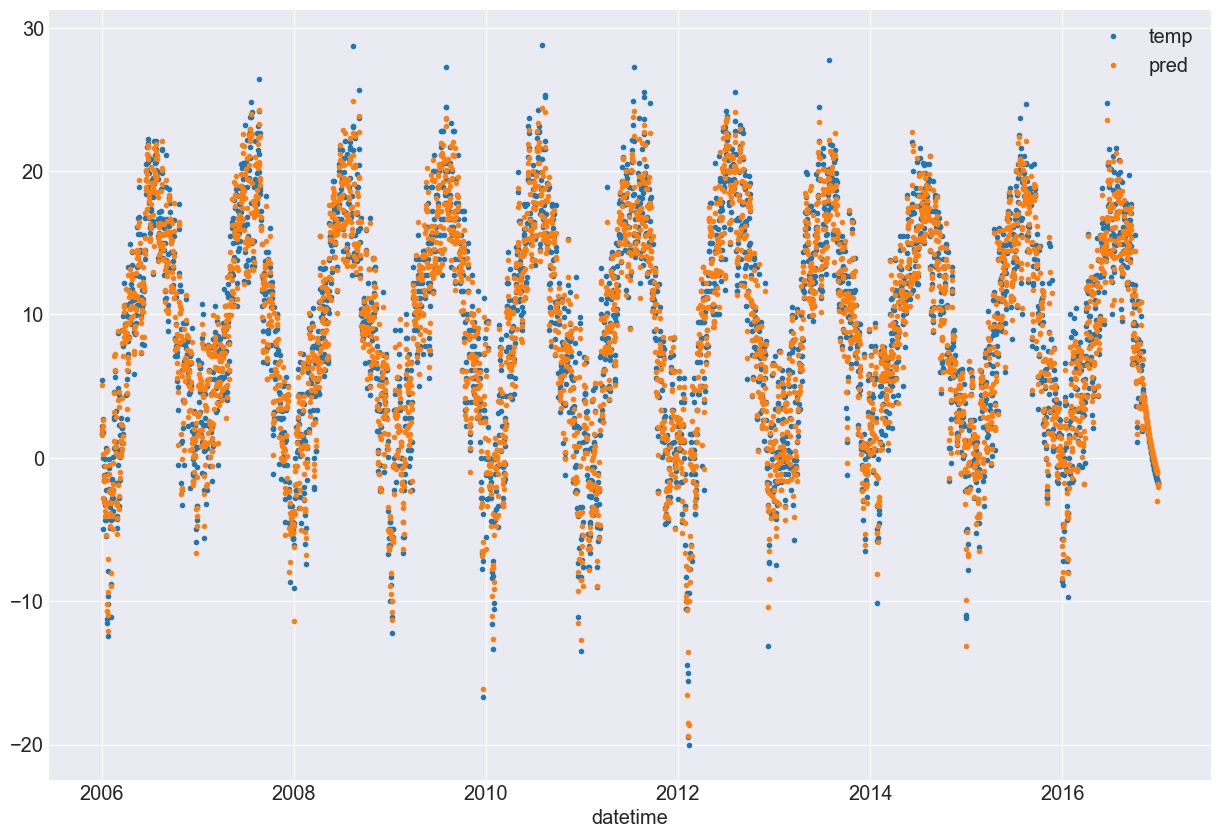

In [29]:
fig,ax = plt.subplots(figsize = (15,10))
res_df.plot(x = 'datetime',y = ['temp','pred'],style = '.',ax = ax)


In [30]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

In [31]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.93,9.55,-21.82,4.69,12.00,18.84,39.91
Apparent Temperature (C),96453.0,10.86,10.70,-27.72,2.31,12.00,18.84,39.34
Humidity,96453.0,0.73,0.20,0.00,0.60,0.78,0.89,1.00
Wind Speed (km/h),96453.0,10.81,6.91,0.00,5.83,9.97,14.14,63.85
Wind Bearing (degrees),96453.0,187.51,107.38,0.00,116.00,180.00,290.00,359.00
Visibility (km),96453.0,10.35,4.19,0.00,8.34,10.05,14.81,16.10
Loud Cover,96453.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Pressure (millibars),96453.0,1003.24,116.97,0.00,1011.90,1016.45,1021.09,1046.38


In [32]:
for col in data_df.columns:
    print(f'{col} : {data_df[col].unique()}')

Formatted Date : ['2006-04-01 00:00:00.000 +0200' '2006-04-01 01:00:00.000 +0200'
 '2006-04-01 02:00:00.000 +0200' ... '2016-09-09 21:00:00.000 +0200'
 '2016-09-09 22:00:00.000 +0200' '2016-09-09 23:00:00.000 +0200']
Summary : ['Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Foggy'
 'Breezy and Mostly Cloudy' 'Clear' 'Breezy and Partly Cloudy'
 'Breezy and Overcast' 'Humid and Mostly Cloudy' 'Humid and Partly Cloudy'
 'Windy and Foggy' 'Windy and Overcast' 'Breezy and Foggy'
 'Windy and Partly Cloudy' 'Breezy' 'Dry and Partly Cloudy'
 'Windy and Mostly Cloudy' 'Dangerously Windy and Partly Cloudy' 'Dry'
 'Windy' 'Humid and Overcast' 'Light Rain' 'Drizzle' 'Windy and Dry'
 'Dry and Mostly Cloudy' 'Breezy and Dry' 'Rain']
Precip Type : ['rain' 'snow' nan]
Temperature (C) : [ 9.472  9.356  9.378 ... 28.472 28.339 30.606]
Apparent Temperature (C) : [ 7.389  7.228  9.378 ... 12.144  9.739  9.233]
Humidity : [0.89 0.86 0.83 0.85 0.95 0.82 0.72 0.67 0.54 0.55 0.51 0.47 0.46 0.6
 0.63 0.69 0.7  0.

In [33]:
data_df[data_df['Precip Type'].isnull()]

,Formatted Date,Summary,Precip Type,Temperature (C),...,Loud Cover,Pressure (millibars),Daily Summary,datetime
52672,2012-04-11 16:00:00.000 +0200,Mostly Cloudy,NaN,19.02,...,0.0,1002.40,Mostly cloudy until night.,2012-04-11 14:00:00+00:00
52674,2012-04-11 18:00:00.000 +0200,Mostly Cloudy,NaN,17.85,...,0.0,1001.79,Mostly cloudy until night.,2012-04-11 16:00:00+00:00
52675,2012-04-11 19:00:00.000 +0200,Mostly Cloudy,NaN,16.32,...,0.0,1001.60,Mostly cloudy until night.,2012-04-11 17:00:00+00:00
52677,2012-04-11 21:00:00.000 +0200,Mostly Cloudy,NaN,12.57,...,0.0,1001.92,Mostly cloudy until night.,2012-04-11 19:00:00+00:00
52678,2012-04-11 22:00:00.000 +0200,Mostly Cloudy,NaN,12.93,...,0.0,1002.20,Mostly cloudy until night.,2012-04-11 20:00:00+00:00
...,...,...,...,...,...,...,...,...,...
95584,2016-10-31 19:00:00.000 +0100,Mostly Cloudy,NaN,8.32,...,0.0,1021.73,Mostly cloudy starting in the afternoon.,2016-10-31 18:00:00+00:00
95585,2016-10-31 20:00:00.000 +0100,Mostly Cloudy,NaN,7.63,...,0.0,1021.76,Mostly cloudy starting in the afternoon.,2016-10-31 19:00:00+00:00
95586,2016-10-31 21:00:00.000 +0100,Mostly Cloudy,NaN,7.11,...,0.0,1021.81,Mostly cloudy starting in the afternoon.,2016-10-31 20:00:00+00:00
95587,2016-10-31 22:00:00.000 +0100,Partly Cloudy,NaN,6.67,...,0.0,1021.83,Mostly cloudy starting in the afternoon.,2016-10-31 21:00:00+00:00


In [34]:
data_df['Precip Type'] = data_df['Precip Type'].fillna('No')
data_df[data_df['Precip Type'].isnull()]

,Formatted Date,Summary,Precip Type,Temperature (C),...,Loud Cover,Pressure (millibars),Daily Summary,datetime


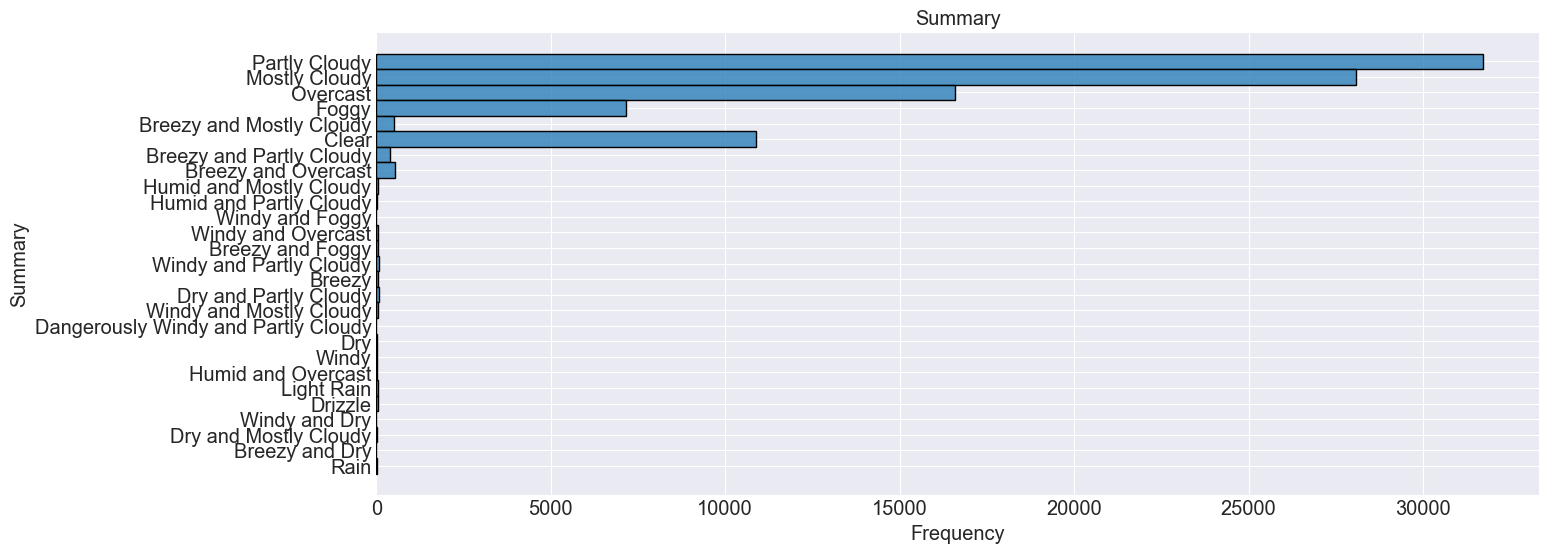

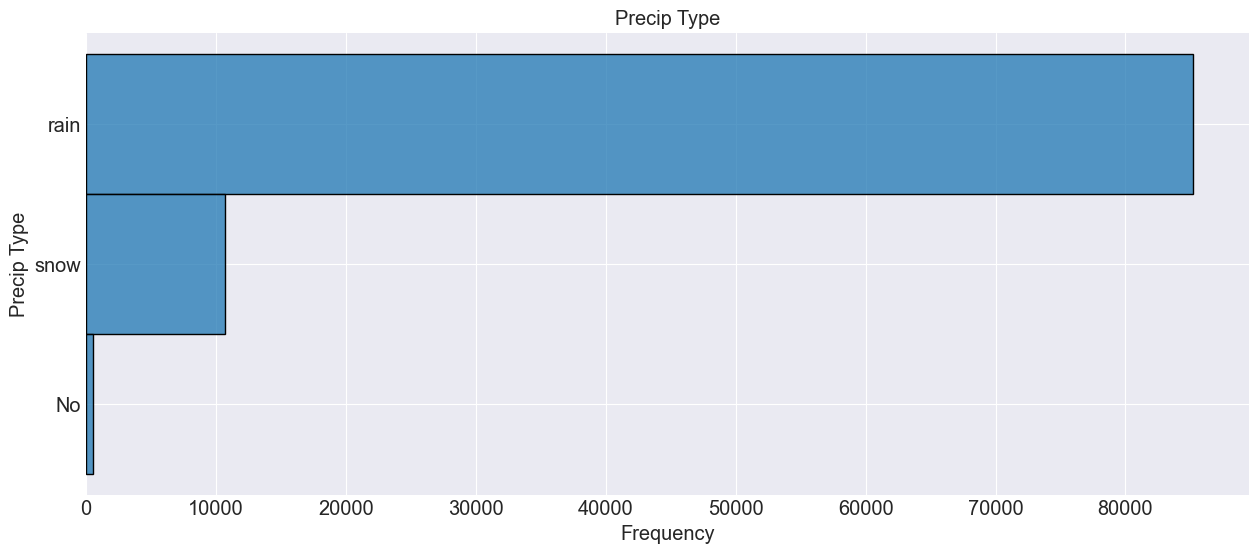

In [35]:
cat_cols = ['Summary', 'Precip Type']

for count, col in enumerate(cat_cols):
                           
    fig, ax = plt.subplots()
    
    colCount = data_df[col].value_counts()
        
    ax.set_title(col)
    
    ax.set_xlabel('Frequency')
    
    #sns.countplot(data_df, y = col, ax = ax)
    sns.histplot(data_df, y = col, ax = ax)

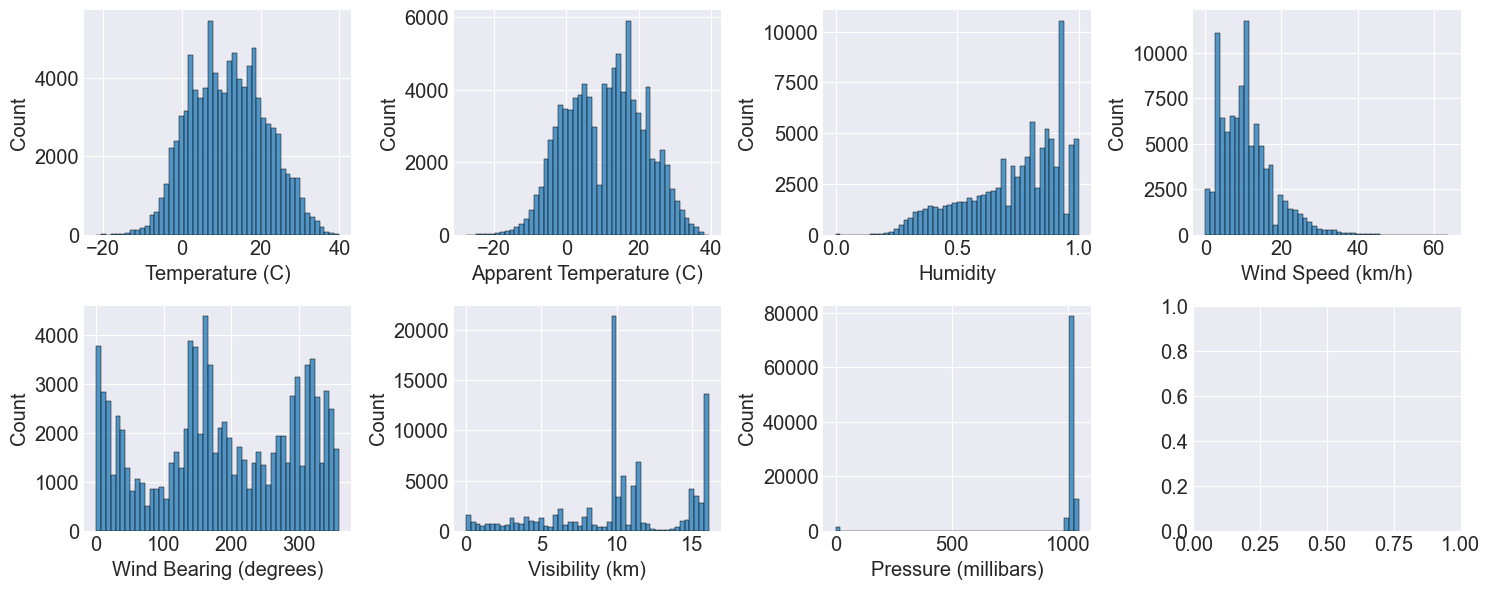

In [36]:
num_cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 
            'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']
fig, axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate(num_cols):
    
    ax =axes[count]
    
    sns.histplot(data_df, x = col, ax = ax, bins = 50)

plt.tight_layout()

In [37]:
data_df.loc[data_df['Pressure (millibars)']<500] ['Precip Type']

858      rain
874      rain
924      rain
945      rain
1074     rain
         ... 
93147    rain
93149    rain
93150    rain
93152    rain
93153    rain
Name: Precip Type, Length: 1288, dtype: object

In [38]:
# calculate class
classmeans = data_df.pivot_table('Pressure (millibars)', columns='Precip Type', aggfunc='mean')
classmeans

Precip Type,No,rain,snow
Pressure (millibars),1019.18,1002.76,1006.22


In [39]:
data_df.loc[data_df['Pressure (millibars)'] == 0]

,Formatted Date,Summary,Precip Type,Temperature (C),...,Loud Cover,Pressure (millibars),Daily Summary,datetime
858,2006-08-14 18:00:00.000 +0200,Partly Cloudy,rain,22.48,...,0.0,0.0,Mostly cloudy until night.,2006-08-14 16:00:00+00:00
874,2006-08-15 10:00:00.000 +0200,Partly Cloudy,rain,21.06,...,0.0,0.0,Partly cloudy until evening.,2006-08-15 08:00:00+00:00
924,2006-08-17 12:00:00.000 +0200,Clear,rain,28.84,...,0.0,0.0,Partly cloudy until morning.,2006-08-17 10:00:00+00:00
945,2006-08-18 09:00:00.000 +0200,Clear,rain,24.95,...,0.0,0.0,Partly cloudy starting overnight continuing un...,2006-08-18 07:00:00+00:00
1074,2006-08-22 18:00:00.000 +0200,Partly Cloudy,rain,23.81,...,0.0,0.0,Partly cloudy starting in the morning.,2006-08-22 16:00:00+00:00
...,...,...,...,...,...,...,...,...,...
93147,2016-03-23 06:00:00.000 +0100,Clear,rain,2.75,...,0.0,0.0,Overcast starting in the afternoon.,2016-03-23 05:00:00+00:00
93149,2016-03-23 08:00:00.000 +0100,Clear,rain,3.84,...,0.0,0.0,Overcast starting in the afternoon.,2016-03-23 07:00:00+00:00
93150,2016-03-23 09:00:00.000 +0100,Clear,rain,5.00,...,0.0,0.0,Overcast starting in the afternoon.,2016-03-23 08:00:00+00:00
93152,2016-03-23 11:00:00.000 +0100,Clear,rain,5.05,...,0.0,0.0,Overcast starting in the afternoon.,2016-03-23 10:00:00+00:00


In [40]:
data_df['Pressure (millibars)'].replace(0, np.nan, inplace=True)
data_df.loc[data_df['Pressure (millibars)'] == 0]

C:\Users\duasp\AppData\Local\Temp\ipykernel_12364\3479904535.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df['Pressure (millibars)'].replace(0, np.nan, inplace=True)


,Formatted Date,Summary,Precip Type,Temperature (C),...,Loud Cover,Pressure (millibars),Daily Summary,datetime


In [41]:
data_df['Pressure (millibars)'] = data_df[['Pressure (millibars)', 'Precip Type']].apply(
    lambda x: classmeans['rain']['Pressure (millibars)'] if pd.isnull(x['Pressure (millibars)']) else
    x['Pressure (millibars)'], axis=1 )

In [42]:
data_df[data_df['Pressure (millibars)'].isnull()]

,Formatted Date,Summary,Precip Type,Temperature (C),...,Loud Cover,Pressure (millibars),Daily Summary,datetime


In [43]:
data_df[['Precip Type', 'Temperature (C)']].groupby(['Precip Type'], as_index = False).mean()

,Precip Type,Temperature (C)
0,No,10.39
1,rain,13.85
2,snow,-3.27


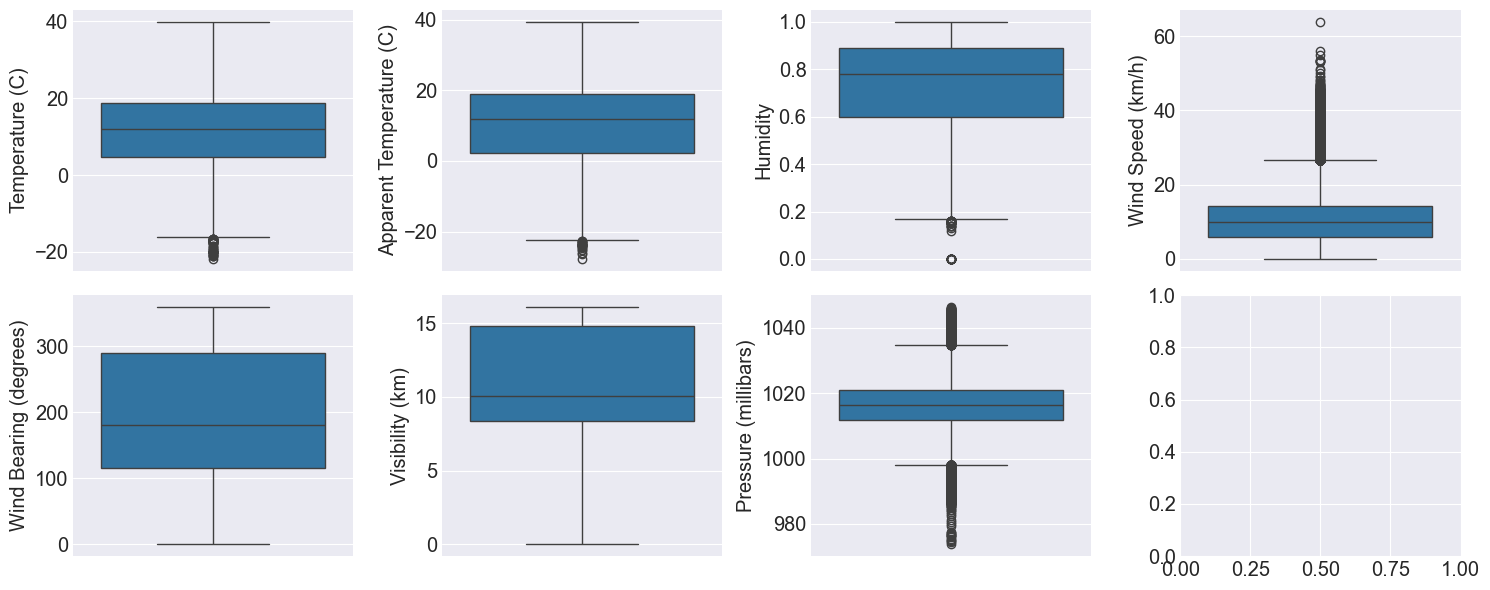

In [44]:
num_cols = ['Temperature (C)','Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Pressure (millibars)']

fig, axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate(num_cols):
    sns.boxplot(y=col, data=data_df, ax = axes[count])

plt.tight_layout()
# Show the plot
plt.show()

In [45]:
data_df[num_cols].corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Temperature (C),1.00e+00,0.99,-6.32e-01,8.96e-03,3.00e-02,0.39,-0.30
Apparent Temperature (C),9.93e-01,1.00,-6.03e-01,-5.66e-02,2.90e-02,0.38,-0.28
Humidity,-6.32e-01,-0.60,1.00e+00,-2.25e-01,7.35e-04,-0.37,0.04
Wind Speed (km/h),8.96e-03,-0.06,-2.25e-01,1.00e+00,1.04e-01,0.10,-0.25
Wind Bearing (degrees),3.00e-02,0.03,7.35e-04,1.04e-01,1.00e+00,0.05,-0.08
Visibility (km),3.93e-01,0.38,-3.69e-01,1.01e-01,4.76e-02,1.00,-0.15
Pressure (millibars),-2.99e-01,-0.28,3.88e-02,-2.53e-01,-7.79e-02,-0.15,1.00


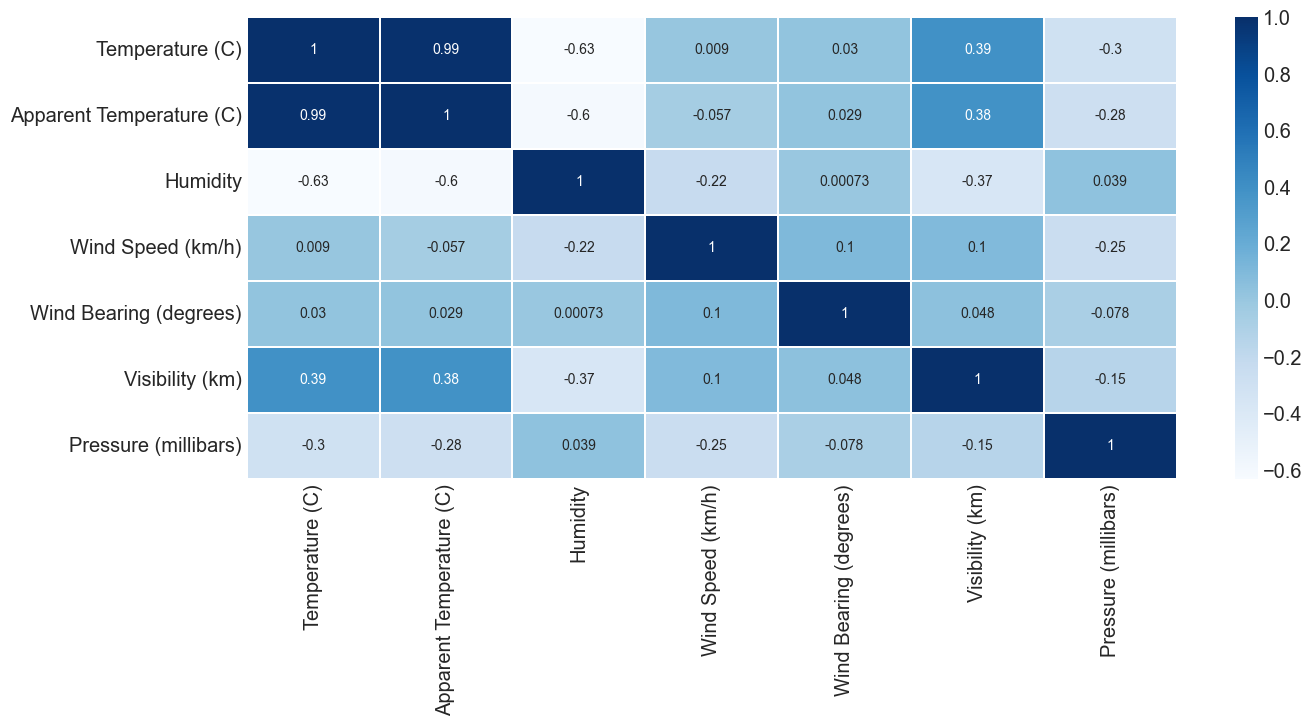

In [46]:
sns.heatmap(data_df[num_cols].corr(), annot=True, cmap=plt.cm.Blues, linewidths = .2)
plt.show()

In [47]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

In [48]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], 
                                     utc=True)

In [49]:
drop_columns = ['Daily Summary', 'Summary', 'Loud Cover', 'Wind Speed (km/h)', 'Wind Bearing (degrees)','Formatted Date'	]
data_df = data_df.drop(drop_columns, axis = 1)
data_df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Visibility (km),Pressure (millibars),datetime
0,rain,9.47,7.39,0.89,15.83,1015.13,2006-03-31 22:00:00+00:00
1,rain,9.36,7.23,0.86,15.83,1015.63,2006-03-31 23:00:00+00:00
2,rain,9.38,9.38,0.89,14.96,1015.94,2006-04-01 00:00:00+00:00
3,rain,8.29,5.94,0.83,15.83,1016.41,2006-04-01 01:00:00+00:00
4,rain,8.76,6.98,0.83,15.83,1016.51,2006-04-01 02:00:00+00:00


In [50]:

le = LabelEncoder()
data_df['Precip Type'] = le.fit_transform(data_df['Precip Type'])
le.classes_

array(['No', 'rain', 'snow'], dtype=object)

In [51]:
tmp_df = data_df.copy()
tmp_df = tmp_df.sort_values('datetime', axis=0, ascending=True)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Visibility (km),Pressure (millibars),datetime
0,1,0.58,-4.05,0.89,9.98,1016.66,2005-12-31 23:00:00+00:00
1,1,1.16,-3.24,0.85,9.90,1016.15,2006-01-01 00:00:00+00:00
2,1,1.67,-3.16,0.82,9.90,1015.87,2006-01-01 01:00:00+00:00
3,1,1.71,-2.19,0.82,9.90,1015.56,2006-01-01 02:00:00+00:00
4,1,1.18,-2.74,0.86,9.90,1014.98,2006-01-01 03:00:00+00:00


In [52]:
tmp_df = tmp_df.rename({'Temperature (C)': 'temp',
                        'Apparent Temperature (C)':'app_t',
                        'Humidity': 'hum',
                        'Pressure (millibars)': 'pres',
                        'Precip Type': 'precip', 
                        'Visibility (km)': 'vis'	}, axis=1)
tmp_df.head()

,precip,temp,app_t,hum,vis,pres,datetime
0,1,0.58,-4.05,0.89,9.98,1016.66,2005-12-31 23:00:00+00:00
1,1,1.16,-3.24,0.85,9.90,1016.15,2006-01-01 00:00:00+00:00
2,1,1.67,-3.16,0.82,9.90,1015.87,2006-01-01 01:00:00+00:00
3,1,1.71,-2.19,0.82,9.90,1015.56,2006-01-01 02:00:00+00:00
4,1,1.18,-2.74,0.86,9.90,1014.98,2006-01-01 03:00:00+00:00


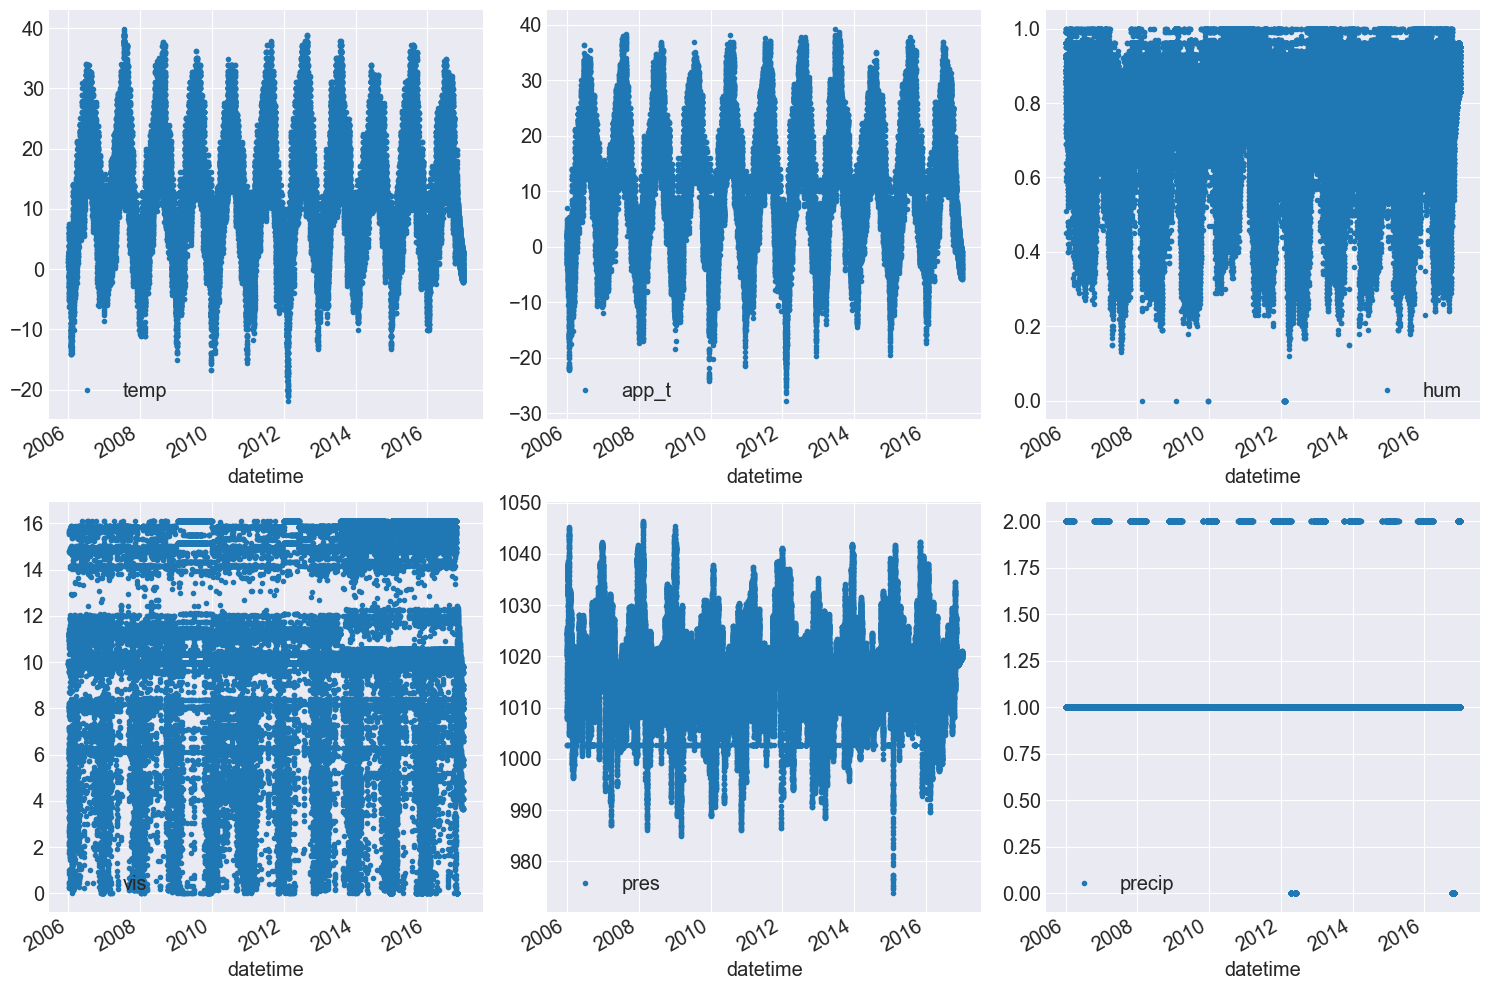

In [53]:
fig = plt.figure(figsize = (15,10))

ax = fig.add_subplot(2, 3, 1)
tmp_df.plot(x='datetime', y='temp', style=".", ax = ax);

ax = fig.add_subplot(2, 3, 2)
tmp_df.plot(x='datetime', y='app_t', style=".", ax = ax);

ax = fig.add_subplot(2, 3, 3)
tmp_df.plot(x='datetime', y='hum', style=".", ax = ax);

ax = fig.add_subplot(2, 3, 4)
tmp_df.plot(x='datetime', y='vis', style=".", ax = ax);


ax = fig.add_subplot(2, 3, 5)
tmp_df.plot(x='datetime', y='pres', style=".", ax = ax);


ax = fig.add_subplot(2, 3, 6)
tmp_df.plot(x='datetime', y='precip', style=".", ax = ax);


plt.tight_layout()

In [54]:
time_step = 24

In [55]:
y_idx = np.arange(time_step, tmp_df.shape[0], time_step)
y_df = tmp_df.iloc[y_idx][['temp', 'datetime']]
y_df.head()

,temp,datetime
24,5.42,2006-01-01 23:00:00+00:00
48,1.69,2006-01-02 23:00:00+00:00
72,2.20,2006-01-03 23:00:00+00:00
96,1.67,2006-01-04 23:00:00+00:00
120,1.81,2006-01-05 23:00:00+00:00


In [56]:
## Limit it to complete days

tmp_df = tmp_df.iloc[range(len(y_df) * time_step)]
tmp_df

,precip,temp,app_t,hum,vis,pres,datetime
0,1,0.58,-4.05,0.89,9.98,1016.66,2005-12-31 23:00:00+00:00
1,1,1.16,-3.24,0.85,9.90,1016.15,2006-01-01 00:00:00+00:00
2,1,1.67,-3.16,0.82,9.90,1015.87,2006-01-01 01:00:00+00:00
3,1,1.71,-2.19,0.82,9.90,1015.56,2006-01-01 02:00:00+00:00
4,1,1.18,-2.74,0.86,9.90,1014.98,2006-01-01 03:00:00+00:00
...,...,...,...,...,...,...,...
96427,2,-0.43,-3.58,0.91,8.40,1020.63,2016-12-30 21:00:00+00:00
96428,2,-0.64,-3.82,0.92,8.87,1020.69,2016-12-30 22:00:00+00:00
96429,2,-0.87,-4.08,0.94,9.79,1020.67,2016-12-30 23:00:00+00:00
96430,2,-1.16,-4.39,0.95,7.33,1020.59,2016-12-31 00:00:00+00:00


In [57]:
tmp_df['temp'].shape, tmp_df.shape

((96432,), (96432, 7))

In [58]:
y_df.shape

(4018, 2)

In [59]:
X_temp = np.reshape(tmp_df['temp'].to_numpy(), (y_df.shape[0], time_step))
X_at = np.reshape(tmp_df['app_t'].to_numpy(), (y_df.shape[0], time_step))
X_hum = np.reshape(tmp_df['hum'].to_numpy(), (y_df.shape[0], time_step))
X_precip = np.reshape(tmp_df['precip'].to_numpy(), (y_df.shape[0], time_step))
X_vis = np.reshape(tmp_df['vis'].to_numpy(), (y_df.shape[0], time_step))
X_pres = np.reshape(tmp_df['pres'].to_numpy(), (y_df.shape[0], time_step))
X_temp.shape

(4018, 24)

In [60]:
# Take 23 cols only 
X_temp = X_temp[:, :23]
X_at = X_at[:, :23]
X_hum = X_hum[:, :23]
X_precip = X_precip[:, :23]
X_vis = X_vis[:, :23]
X_pres = X_pres[:, :23]
X_temp.shape

(4018, 23)

In [61]:
# play with what features you want to use
X_data = np.stack((X_temp, 
                   X_at , 
                   X_hum , 
                   #X_precip, 
                   #X_vis, 
                   #X_pres
                  ), axis = 2)
#X_data = np.reshape(X_temp, (X_temp.shape[0], X_temp.shape[1], 1))
X_data.shape

(4018, 23, 3)

In [62]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X_data[:split]
X_test = X_data[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 3), (804, 23, 3), (3214,), (804,))

In [63]:
h_units = 64 # number of units in the RNN

input_shape=(time_step-1, X_train.shape[2] ) # we are using five features

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(input_shape))

model.add(tf.keras.layers.SimpleRNN(units = h_units, 
                                    activation = 'tanh'))

model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [64]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 64)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                           patience=PATIENCE,
                                                           mode='auto',
                                                           baseline =None,
                                                           restore_best_weights=True)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=LR_FACTOR,
                                                 patience=LR_PATIENCE,
                                                 verbose=0
                                                )

In [66]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=2,
                    callbacks = [early_stopping_callback, reduce_lr])

Epoch 1/30
101/101 - 1s - 13ms/step - loss: 42.0523 - root_mean_squared_error: 6.4941 - val_loss: 9.7793 - val_root_mean_squared_error: 3.1794 - learning_rate: 0.0010
Epoch 2/30
101/101 - 0s - 2ms/step - loss: 10.3886 - root_mean_squared_error: 3.2254 - val_loss: 3.5946 - val_root_mean_squared_error: 1.9284 - learning_rate: 0.0010
Epoch 3/30
101/101 - 0s - 2ms/step - loss: 4.8221 - root_mean_squared_error: 2.1978 - val_loss: 1.7640 - val_root_mean_squared_error: 1.3510 - learning_rate: 0.0010
Epoch 4/30
101/101 - 0s - 2ms/step - loss: 2.8420 - root_mean_squared_error: 1.6878 - val_loss: 1.1401 - val_root_mean_squared_error: 1.0854 - learning_rate: 0.0010
Epoch 5/30
101/101 - 0s - 2ms/step - loss: 2.0195 - root_mean_squared_error: 1.4230 - val_loss: 0.8997 - val_root_mean_squared_error: 0.9638 - learning_rate: 0.0010
Epoch 6/30
101/101 - 0s - 2ms/step - loss: 1.6194 - root_mean_squared_error: 1.2743 - val_loss: 0.7881 - val_root_mean_squared_error: 0.9021 - learning_rate: 0.0010
Epoch 7

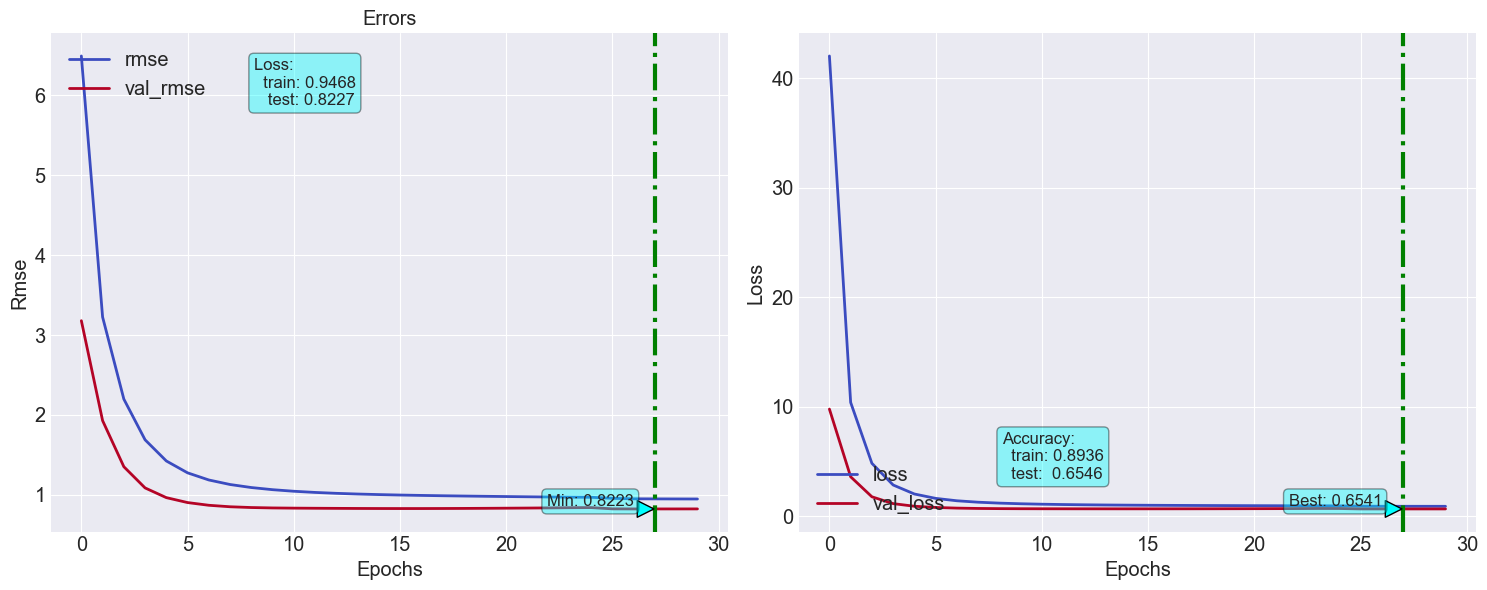

In [67]:
hist_df = pd.DataFrame(history.history)
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 'val_root_mean_squared_error' : 'val_rmse'}, axis=1)


fn_plot_tf_hist(hist_df)
#.8172

In [68]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


In [69]:
y_df.head()

,temp,datetime
24,5.42,2006-01-01 23:00:00+00:00
48,1.69,2006-01-02 23:00:00+00:00
72,2.20,2006-01-03 23:00:00+00:00
96,1.67,2006-01-04 23:00:00+00:00
120,1.81,2006-01-05 23:00:00+00:00


In [70]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,temp,datetime,pred
24,5.42,2006-01-01,5.20
48,1.69,2006-01-02,1.59
72,2.20,2006-01-03,1.85
96,1.67,2006-01-04,2.06
120,1.81,2006-01-05,2.32


In [71]:
res_df.tail()

,temp,datetime,pred
96336,-1.63,2016-12-27,-1.65
96360,-1.68,2016-12-28,-1.75
96384,-1.73,2016-12-29,-1.84
96408,-1.78,2016-12-30,-1.93
96432,-1.82,2016-12-31,-2.00


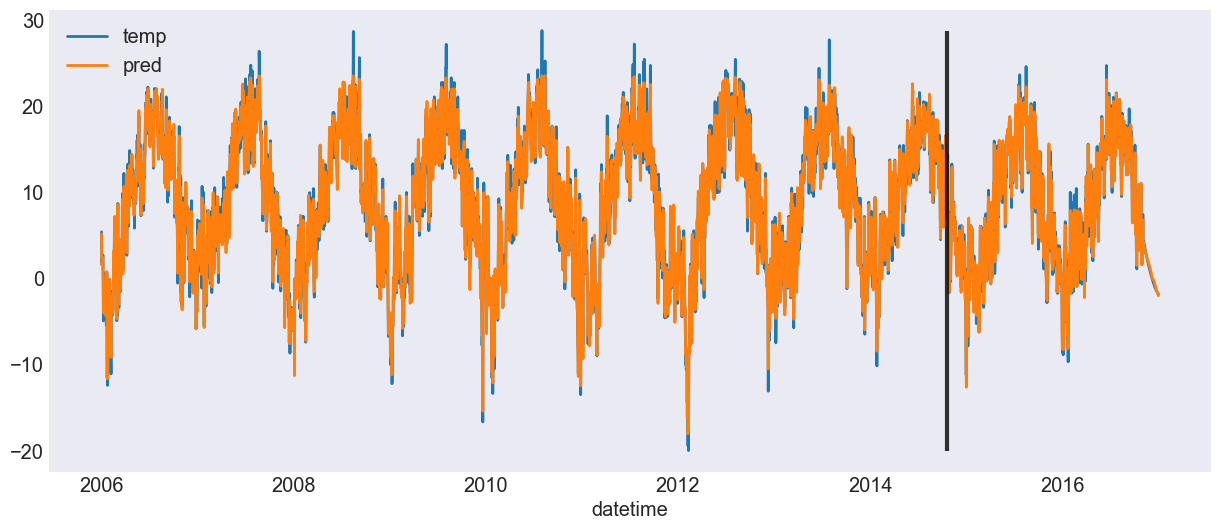

In [72]:
fig, ax = plt.subplots(figsize = (15,6))

res_df.plot(x='datetime', y=['temp','pred'], ax = ax);

ax.vlines(res_df.iloc[X_train.shape[0]]['datetime'], 
          res_df['temp'].min(), 
          res_df['temp'].max(), color = 'k', 
          linewidth=3.0, zorder=10, alpha =0.8)

ax.grid()